# Testing momentum distributions using single-particle wave functions
## Version 1

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ January 23, 2023

This notebook serves as a testbed for calculating momentum distributions using mean field approximations for initial and final states and applying SRG transformations to the operator. This differs from the previous momentum distribution calculations by directly utilizing single-particle wave functions instead of a local density approximation.

_Last update:_ February 6, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.special import spherical_jn, sph_harm
import shutil
from sympy.physics.quantum.cg import CG
import time
import vegas

In [2]:
# Imports from scripts
from scripts.figures import label_nucleus, set_rc_parameters
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix
)
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import coupled_channel
from scripts.woodsaxon import ws

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/spectroscopic_factors/'
vmc_directory = '../data/vmc/momentum_distributions/'

## Classes

In [5]:
class SingleParticleState:
    
    
    def __init__(self, n, l, j, m_j, tau):
        self.n = n
        self.l = l
        self.j = j
        self.m_j = m_j
        self.tau = tau
        if tau == 1/2:
            self.nucleon = 'proton'
        elif tau == -1/2:
            self.nucleon = 'neutron'
        
        
    def __eq__(self, sp_state):
        if (
            self.n == sp_state.n and self.l == sp_state.l
            and self.j == sp_state.j and self.m_j == sp_state.m_j
            and self.tau == sp_state.tau
        ):
            return True
        else:
            return False
        
        
    def __str__(self):
        l_str = convert_l_to_string(self.l)  # E.g., 's', 'p', 'd', ...
        numerator = 2*int(self.j) + 1
        denominator = 2

        return fr"${self.n}{l_str}_{{{numerator}/{denominator}}}$"

In [6]:
class SingleParticleBasis:
    """
    Single-particle basis class. Handles the wave functions associated with the
    Wood-Saxon potential from the subroutine in woodsaxon.f90. Generates wave
    functions in coordinate and momentum space.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    n_max : int
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
        
    """
    
    
    def __init__(self, nucleus_name, Z, N, n_max, l_max, rmax=40, ntab=2000):

        # Generate orbitals
        self.run_wood_saxon_code(nucleus_name, Z, N, n_max, l_max, rmax, ntab)
                
        # Order single-particle states with lowest energy first
        self.order_sp_states(Z, N)
        
        # Move output files to relevant directory
        wood_saxon_directory = f"../data/wood_saxon/{nucleus_name}/"
        shutil.move("ws_log", wood_saxon_directory + "ws_log")
        shutil.move("ws_pot", wood_saxon_directory + "ws_pot")
        shutil.move("ws_rho", wood_saxon_directory + "ws_rho")

        # Move orbital files and organize wave functions in dictionary with
        # the file name as the key
        self.sp_wfs = {}
        for sp_state in self.sp_states:
            # Wave functions are independent of m_j, so fix m_j=j
            if sp_state.m_j == sp_state.j:
                file_name = self.get_orbital_file_name(sp_state)
                shutil.move(file_name, wood_saxon_directory + file_name)
                data = np.loadtxt(wood_saxon_directory + file_name)
                # Use file name as the key
                self.sp_wfs[file_name] = data[:, 1]

            
    def run_wood_saxon_code(
            self, nucleus_name, Z, N, n_max, l_max, rmax, ntab):
        """Run Wood-Saxon code to generate data."""
        
        # Total number of nucleons
        A = Z + N
        
        # Type of orbitals: 1 - nucleons with no Coulomb
        #                   2 - distinguish protons and neutrons
        ntau = 2
        
        # Orbitals to consider (note, we track 2*j not j)
        norb, lorb, jorb = [], [], []
        for n in range(1, n_max+1):
            for l in range(0, l_max+1):
                norb.append(n)
                lorb.append(l)
                jorb.append(int(2*(l+1/2)))
                if int(2*(l-1/2)) > 0:  # Don't append negative j
                    norb.append(n)
                    lorb.append(l)
                    jorb.append(int(2*(l-1/2)))
        nrad = len(jorb)
        orbws = np.zeros(shape=(2,nrad,ntab), order='F')
    
        # Divide orbital by r? -> get R(r); false: get u(r)=r R(r)
        rdiv = False
        dens = True
    
        # Set parameters of the Wood-Saxon potential
        prm = np.zeros(shape=(2,9), order='F')
    
        # Starting with vws (p & n)
        if nucleus_name == 'He4':
            prm[:,0] = 76.8412
            # prm[:,0] = 90.0  # For bound 1p_{1/2} state
        elif nucleus_name == 'O16':
            prm[:,0] = 58.0611
        elif nucleus_name == 'Ca40':
            prm[:,0] = 54.3051
        elif nucleus_name == 'Ca48':
            prm[0,0] = 59.4522
            prm[1,0] = 46.9322
    
        # Not sure about these (better way to load these parameters?)
        prm[:,1] = 1.275
        prm[:,2] = 0.7
        prm[:,3] = 0.
        prm[:,4] = 1.
        prm[:,5] = 36
        prm[:,6] = 1.32
        prm[:,7] = 0.7
        prm[:,8] = 1.275
        
        # Print summary, potentials, and densities
        prnt = True
        prntorb = True

        # Run Fortran subroutine
        ws(ntau, A, Z, rmax, orbws, norb, lorb, jorb, prm, rdiv, prnt, prntorb,
           dens)

        # Set radial distance array and step-size as instance attributes
        self.dr = rmax / ntab
        self.r_array = np.arange(self.dr, rmax + self.dr, self.dr)
        
        
    def order_sp_states(self, Z, N):
        """Keep track of all s.p. states and occupied s.p. states"""

        self.sp_states = []
        self.occ_states = []
        proton_count = 0
        neutron_count = 0
    
        # Order single-particle states using the ws_log file
        with open('ws_log', 'r') as f:
            for line in f:
                unit = line.strip().split()
                
                # Protons
                if len(unit) > 0 and unit[0] == '1':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, 1/2
                        )  # n, l, j, m_j, \tau
                    
                        self.sp_states.append(sp_state)
                    
                        if proton_count < Z:
                            self.occ_states.append(sp_state)
                            # Add up filled proton states
                            proton_count += 1
                    
                
                # Neutrons
                elif len(unit) > 0 and unit[0] == '2':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, -1/2
                        )  # n, l, j, m_j, \tau
                    
                        self.sp_states.append(sp_state)
                    
                        if neutron_count < N:
                            self.occ_states.append(sp_state)
                            # Add up filled neutron states
                            neutron_count += 1
                        
                        
    def get_orbital_file_name(self, sp_state):
        """Returns the file name of the orbital."""
        
        n, l, j = sp_state.n, sp_state.l, sp_state.j
        # Proton
        if sp_state.tau == 1/2:
            file_name = f"p.n{int(n-1)}.l{l}.j{int(2*j)}.orb"
        # Neutron
        elif sp_state.tau == -1/2:
            file_name = f"n.n{int(n-1)}.l{l}.j{int(2*j)}.orb"
        
        return file_name
                        
    
    def get_wf_rspace(self, sp_state, print_normalization=False):
        """Single-particle wave function in coordinate space."""
        
        # Orbital file name is the key
        u_array = self.sp_wfs[self.get_orbital_file_name(sp_state)]

        # Normalization: \int dr |u(r)|^2 = 1
        if print_normalization:
            normalization = np.sum(self.dr*u_array**2)
            print(f"Coordinate space normalization = {normalization}.")

        return self.r_array, u_array
    
    
    def fourier_transformation(self, l, k_array):
        """Fourier transformation matrix for given orbital angular momentum."""
        
        # r_array column vectors and k_array row vectors where both grids are
        # n x m matrices
        r_cols, k_rows = np.meshgrid(self.r_array, k_array)
        
        # Transformation matrix with shape n x m, where m is the length of
        # r_array and n is the length of the k_array
        M = 1j**(-l) * np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(
            l, k_rows*r_cols
        )
        
        return M
    
    
    def get_wf_kspace(
            self, sp_state, print_normalization=False, interpolate=False,
            kmax=15.0, kmid=3.0, ntot=120):
        """Single-particle wave function in momentum space."""
    
        # Set momentum mesh with more points at low momentum
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        _, u_array = self.get_wf_rspace(sp_state)

        # Fourier-transform the wave function to momentum space
        phi_array = self.fourier_transformation(sp_state.l, k_array) @ u_array
    
        # Normalization: \int dk k^2 |\phi(k)|^2 = 1
        if print_normalization:
            normalization = np.sum(k_weights*k_array**2*abs(phi_array)**2)
            print(f"Momentum space normalization = {normalization}.")
            
        # Interpolate and return function?
        if interpolate:
            phi_func = interp1d(k_array, phi_array, kind='linear',
                                bounds_error=False, fill_value='extrapolate')
            return phi_func
        
        # Otherwise return momentum, weights, and \phi(k)
        else:
            return k_array, k_weights, phi_array

In [7]:
# Add docstring
class MomentumDistribution(SingleParticleBasis):
    
    
    def __init__(
        self, nucleus_name, Z, N, n_max, l_max, channels, kvnn, rmax=40,
        ntab=2000, kmax=15.0, kmid=3.0, ntot=120, generator='Wegner', lamb=1.35
    ):
        
        # Call SingleParticleBasis class given the specifications
        super().__init__(nucleus_name, Z, N, n_max, l_max, rmax, ntab)
        
        # Set instance attributes
        self.nucleus_name = nucleus_name
        self.channels = channels
        self.kvnn = kvnn
        self.kmax = kmax
        self.kmid = kmid
        self.ntot = ntot
        self.generator = generator
        self.lamb = lamb
        
        # Spin projections
        self.spins = np.array([1/2, -1/2])
        
        # Set Clebsch-Gordan table with j_max = 4
        self.cg_table = self.set_clebsch_gordan_table(4)
        
        # Set interpolating functions for s.p. wave functions \phi
        self.set_sp_wave_functions()
        
        # Set interpolating functions for \delta U and \delta U^\dagger
        self.set_delta_U_functions()
        
    
    def set_clebsch_gordan_table(self, j_max):
        """
        Calculate Clebsch-Gordan coefficients for all combinations of j and m_j
        up to j_max.
    
        Parameters
        ----------
        j_max : int
            Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
        Returns
        -------
        cg_table : dict
            Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
            for each combination of angular momenta.
        
        """
        
        cg_table = {}
        
        j_array = np.arange(0, j_max+1/2, 1/2)

        for j_1 in j_array:
            for m_1 in np.arange(-j_1, j_1+1, 1):
                for j_2 in j_array:
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        for j_3 in j_array:
                            for m_3 in np.arange(-j_3, j_3+1, 1):
                                cg_table[(j_1,m_1,j_2,m_2,j_3,m_3)] = float(
                                    CG(j_1,m_1,j_2,m_2,j_3,m_3).doit()
                                )
                                
        return cg_table
    
    
    def set_sp_wave_functions(self):
        """Set interpolating functions for s.p. wave functions \phi."""

        self.phi_functions = {}
        for sp_state in self.occ_states: 
            file_name = self.get_orbital_file_name(sp_state)
            self.phi_functions[file_name] = self.get_wf_kspace(sp_state,
                                                               interpolate=True)
            
    def psi(self, sp_state, q_vector, sigma, tau):
        """Single-particle wave function including the Clebsch-Gordan
        coefficient and spherical harmonic.
        """
        
        # Check that \tau = s.p. state \tau
        if sp_state.tau != tau:
            return 0
        
        # Unpack q_vector into magnitude and angles
        q = la.norm(q_vector)
        theta = np.arccos(q_vector[2]/q)
        phi = np.arctan2(q_vector[1], q_vector[0])
        
        # Calculate \phi_\alpha(q)
        phi_sp_wf = self.phi_functions[self.get_orbital_file_name(sp_state)](q)
    
        # m_l is determined by m_j and \sigma
        m_l = sp_state.m_j - sigma
        
        # Check that m_l is allowed
        if abs(m_l) > sp_state.l:
            return 0
        
        # Clebsch-Gordan coefficient
        cg = self.cg_table[(sp_state.l, m_l, 1/2, sigma, sp_state.j,
                            sp_state.m_j)]
        
        # Spherical harmonic
        Y_lm = sph_harm(m_l, sp_state.l, phi, theta)

        return phi_sp_wf * cg * Y_lm
    
    
    def interpolate_delta_U(self, channel, hermitian_conjugate=False):
        """Interpolate \delta U(k, k') for the given channel."""
    
        # Set channel argument to be compatible with potential functions
        if channel[:3] in ['3S1', '3D1']:
            channel_arg = '3S1'
        elif channel[:3] in ['3P2', '3F2']:
            channel_arg = '3P2'
        elif channel[:3] in ['3D3', '3G3']:
            channel_arg = '3D3'
        else:
            channel_arg = channel[:3]
        
        # Set potential
        potential = Potential(self.kvnn, channel_arg, self.kmax, self.kmid,
                              self.ntot)
    
        # Get momentum mesh
        k_array, k_weights = potential.load_mesh()
    
        # Initial and evolved Hamiltonians
        H_initial = potential.load_hamiltonian()
        if self.generator == 'Block-diag':
            H_evolved = potential.load_hamiltonian('srg', self.generator, 1.0,
                                                   lambda_bd=self.lamb)
        else:
            H_evolved = potential.load_hamiltonian('srg', self.generator,
                                                   self.lamb)
    
        # Get SRG transformation from Hamiltonians
        U_matrix_weights = get_transformation(H_initial, H_evolved)
    
        # Calculate \delta U = U - I
        I_matrix_weights = np.eye(len(U_matrix_weights), len(U_matrix_weights))
        if hermitian_conjugate:
            delU_matrix_weights = (U_matrix_weights - I_matrix_weights).T
        else:
            delU_matrix_weights = U_matrix_weights - I_matrix_weights

        # Get specific sub-block if coupled-channel
        n = self.ntot
        if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            delU_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delU_matrix_weights[:n,n:2*n]
            )
        elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            delU_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delU_matrix_weights[n:2*n,:n]
            )
        elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            delU_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delU_matrix_weights[n:2*n,n:2*n]
            )
        else:
            delU_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delU_matrix_weights[:n,:n]
            )
        
        # Interpolate \delta U(k, k')
        delU_func = RectBivariateSpline(k_array, k_array, delU_matrix)

        return delU_func
    
    
    def set_delta_U_functions(self):
        """Save \delta U and \delta U^\dagger functions to dictionary."""

        self.delta_U_functions = {}
        self.delta_U_dagger_functions = {}
        for channel in self.channels:
            self.delta_U_functions[channel] = self.interpolate_delta_U(channel)
            self.delta_U_dagger_functions[channel] = (
                self.interpolate_delta_U(channel, hermitian_conjugate=True)
            )
            
            
    def get_channel_str(self, Lp, L, S, J):
        """Gets the partial wave channel string given quantum numbers."""
    
        # Total orbital angular momentum L' = 0, 1, 2, ...
        if Lp == 0:
            Lp_str = 'S'
        elif Lp == 1:
            Lp_str = 'P'
        elif Lp == 2:
            Lp_str = 'D'
        elif Lp == 3:
            Lp_str = 'F'
        elif Lp == 4:
            Lp_str = 'G'
        elif Lp == 5:
            Lp_str = 'H'
        else:
            raise RuntimeError("Channel L' exceeds the range of the function.")
        
        channel = f"{2*S+1}{Lp_str}{J}"
    
        # Total orbital angular momentum L = 0, 1, 2, ...
        # L = L' if the channel is not coupled
        if channel in ['3S1', '3D1', '3P2', '3F2', '3D3', '3G3']:
        
            if L == 0:
                L_str = 'S'
            elif L == 1:
                L_str = 'P'
            elif L == 2:
                L_str = 'D'
            elif L == 3:
                L_str = 'F'
            elif L == 4:
                L_str = 'G'
            elif L == 5:
                L_str = 'H'
            else:
                raise RuntimeError(
                    "Channel L exceeds the range of the function."
                )
            
            channel += f"-{2*S+1}{L_str}{J}"

        return channel
            
            
    def get_channel_quantum_numbers(self, channel):
        """Gets the quantum numbers of a partial wave channel."""
    
        # Total orbital angular momentum L' = 0, 1, 2, ...
        if channel[1] == 'S':
            Lp = 0
        elif channel[1] == 'P':
            Lp = 1
        elif channel[1] == 'D':
            Lp = 2
        elif channel[1] == 'F':
            Lp = 3
        elif channel[1] == 'G':
            Lp = 4
        elif channel[1] == 'H':
            Lp = 5
        else:
            raise RuntimeError("Channel L' exceeds the range of the function.")
    
        # Total orbital angular momentum L = 0, 1, 2, ...
        if coupled_channel(channel[:3]):
        
            if channel[5] == 'S':
                L = 0
            elif channel[5] == 'P':
                L = 1
            elif channel[5] == 'D':
                L = 2
            elif channel[5] == 'F':
                L = 3
            elif channel[5] == 'G':
                L = 4
            elif channel[5] == 'H':
                L = 5
            else:
                raise RuntimeError(
                    "Channel L exceeds the range of the function."
                )
        
        # L = L' if the channel is not coupled
        else:
        
            L = Lp
        
        # Total spin S = 0 or 1
        S = int((int(channel[0])-1)/2)
    
        # Total angular momentum J = 0, 1, 2, ...
        J = int(channel[2])
            
        return Lp, L, S, J
    
    
    def get_total_isospin(self, L, S):
        """Total isospin according to antisymmetry."""
    
        # Make sure [1-(-1)^(L+S+T)] is not zero
        if (1-(-1)**(L+S)) == 0:
            T = 1
        else:
            T = 0
        
        return T
    
    
    def delta_U_matrix_element(
            self, k_vector, kp_vector, sigma_1, sigma_2, sigma_3, sigma_4,
            tau_1, tau_2, tau_3, tau_4, hermitian_conjugate=False
    ):
        """Returns the plane-wave matrix element of \delta U."""
        
        # Check spin conservation
        if sigma_1 + sigma_2 != sigma_3 + sigma_4:
            return 0
        
        # Check isospin conservation
        if tau_1 + tau_2 != tau_3 + tau_4:
            return 0
        
        # Unpack k_vector and k'_vector into their magnitudes and angles
        k = la.norm(k_vector)
        theta_k = np.arccos(k_vector[2]/k)
        phi_k = np.arctan2(k_vector[1], k_vector[0])
        kp = la.norm(kp_vector)
        theta_kp = np.arccos(kp_vector[2]/kp)
        phi_kp = np.arctan2(kp_vector[1], kp_vector[0])

        # Set total spin and total isospin projections
        M_S = sigma_1 + sigma_2
        M_T = tau_1 + tau_2
        
        # Loop over partial wave channels
        delta_U_matrix_element = 0
        for channel in self.channels:
            
            # Determine channel quantum numbers
            L, Lp, S, J = self.get_channel_quantum_numbers(channel)
            
            # Determine total isospin
            T = self.get_total_isospin(L, S)
            
            # Only proceed forward if |M_S| <= S and |M_T| <= T
            if abs(M_S) <= S and abs(M_T) <= T:
            
                # Calculate 1-(-1)^(L'+S+T) and 1-(-1)^(L+S+T) factors
                factor = (1-(-1)**(Lp+S+T)) * (1-(-1)**(L+S+T))
            
                # Spin CG's
                spin_12_cg = self.cg_table[(1/2, sigma_1, 1/2, sigma_2, S, M_S)]
                spin_34_cg = self.cg_table[(1/2, sigma_3, 1/2, sigma_4, S, M_S)]
                    
                # Isospin CG's
                isospin_12_cg = self.cg_table[(1/2, tau_1, 1/2, tau_2, T, M_T)]
                isospin_34_cg = self.cg_table[(1/2, tau_3, 1/2, tau_4, T, M_T)]

                # \delta U(k, k') or \delta U^\dagger(k, k')
                if hermitian_conjugate:
                    delta_U_partial_wave = (
                        self.delta_U_dagger_functions[channel].ev(k, kp)
                    )
                else:
                    delta_U_partial_wave = (
                        self.delta_U_functions[channel].ev(k, kp)
                    )

                # Loop over possible M_J values
                M_J_array = np.arange(-J, J+1, 1)
                for M_J in M_J_array:
                
                    # M_L and M_L' are fixed
                    M_L = M_J - M_S
                    M_Lp = M_J - M_S
                
                    # Only proceed forward if |M_L| <= L and |M_L'| <= L'
                    if abs(M_L) <= L and abs(M_Lp) <= Lp:
                    
                        # L-S coupling CG's
                        L_S_J_cg = self.cg_table[(L, M_L, S, M_S, J, M_J)]
                        Lp_S_J_cg = self.cg_table[(Lp, M_Lp, S, M_S, J, M_J)]
                    
                        # Spherical harmonics
                        Y_L = sph_harm(M_L, L, phi_k, theta_k)
                        Y_Lp = np.conj(sph_harm(M_Lp, Lp, phi_kp, theta_kp))

                        delta_U_matrix_element += (
                            1/2 * 2/np.pi * spin_12_cg * spin_34_cg
                            * isospin_12_cg * isospin_34_cg * L_S_J_cg
                            * Lp_S_J_cg * factor * Y_L * Y_Lp
                            * delta_U_partial_wave
                        )
                        
        return delta_U_matrix_element
            
    
    def delta_U2_matrix_elements(
            self, k_vector, qK_vector, kp_vector, sigma_1, sigma_2, sigma,
            sigmap, sigma_3, sigma_4, tau_1, tau_2, tau, taup, tau_3, tau_4
    ):
        """Returns the plane-wave matrix elements of \delta U^2."""
        
        # Check spin conservation
        if sigma_1 + sigma_2 != sigma + sigmap:
            return 0
        if sigma + sigmap != sigma_3 + sigma_4:
            return 0
        
        # Check isospin conservation
        if tau_1 + tau_2 != tau + taup:
            return 0
        if tau + taup != tau_3 + tau_4:
            return 0
        
        # Unpack vectors into their magnitudes and angles
        k = la.norm(k_vector)
        theta_k = np.arccos(k_vector[2]/k)
        phi_k = np.arctan2(k_vector[1], k_vector[0])
        
        qK = la.norm(qK_vector)
        theta_qK = np.arccos(qK_vector[2]/qK)
        phi_qK = np.arctan2(qK_vector[1], qK_vector[0])
        
        kp = la.norm(kp_vector)
        theta_kp = np.arccos(kp_vector[2]/kp)
        phi_kp = np.arctan2(kp_vector[1], kp_vector[0])

        # Set total spin and total isospin projections
        M_S = sigma + sigmap
        M_T = tau + taup
        
        # Loop over partial wave channels
        delta_U2_matrix_element = 0
        for channel in self.channels:
            
            # Determine channel quantum numbers
            L, Lp, S, J = self.get_channel_quantum_numbers(channel)
            
            # Determine total isospin
            T = self.get_total_isospin(L, S)
            
            # Only proceed forward if |M_S| <= S and |M_T| <= T
            if abs(M_S) <= S and abs(M_T) <= T:
            
                # Calculate 1-(-1)^(L'+S+T) and 1-(-1)^(L+S+T) factors
                factor = ((1-(-1)**(L+S+T)) * (1-(-1)**(Lp+S+T))
                          * (1-(-1)**(Lp+S+T)) * (1-(-1)**(L+S+T)))
            
                # Spin CG's
                spin_12_cg = self.cg_table[(1/2, sigma_1, 1/2, sigma_2, S, M_S)]
                spin_ssp_cg = self.cg_table[(1/2, sigma, 1/2, sigmap, S, M_S)]
                spin_34_cg = self.cg_table[(1/2, sigma_3, 1/2, sigma_4, S, M_S)]
                    
                # Isospin CG's
                isospin_12_cg = self.cg_table[(1/2, tau_1, 1/2, tau_2, T, M_T)]
                isospin_ttp_cg = self.cg_table[(1/2, tau, 1/2, taup, T, M_T)]
                isospin_34_cg = self.cg_table[(1/2, tau_3, 1/2, tau_4, T, M_T)]
                
                # Get channel string for calling \delta U functions           
                channel_1 = self.get_channel_str(L, Lp, S, J)
                channel_2 = self.get_channel_str(Lp, L, S, J)
                
                # \delta U(k, q-K/2) and \delta U^\dagger(q-K/2, k')
                delta_U_partial_wave = (
                    self.delta_U_functions[channel_1].ev(k, qK)
                )
                delta_U_dag_partial_wave = (
                    self.delta_U_dagger_functions[channel_2].ev(qK, kp)
                )

                # Loop over possible M_J values
                M_J_array = np.arange(-J, J+1, 1)
                for M_J in M_J_array:
                
                    # M_L and M_L' are fixed
                    M_L = M_J - M_S
                    M_Lp = M_J - M_S
                
                    # Only proceed forward if |M_L| <= L and |M_L'| <= L'
                    if abs(M_L) <= L and abs(M_Lp) <= Lp:
                    
                        # L-S coupling CG's
                        L_S_J_cg = self.cg_table[(L, M_L, S, M_S, J, M_J)]
                        Lp_S_J_cg = self.cg_table[(Lp, M_Lp, S, M_S, J, M_J)]
                    
                        # Spherical harmonics
                        Y_L_k = sph_harm(M_L, L, phi_k, theta_k)
                        Y_Lp_qK = sph_harm(M_Lp, Lp, phi_qK, theta_qK)
                        Y_L_kp = np.conj(sph_harm(M_L, L, phi_kp, theta_kp))

                        delta_U2_matrix_element += (
                            (1/2 * 2/np.pi)**2 * spin_12_cg * spin_ssp_cg**2
                            * spin_34_cg * isospin_12_cg * isospin_ttp_cg**2
                            * isospin_34_cg * L_S_J_cg**2 * Lp_S_J_cg**2
                            * factor * Y_L_k * np.conj(Y_Lp_qK) * Y_Lp_qK
                            * Y_L_kp * delta_U_partial_wave
                            * delta_U_dag_partial_wave
                        )
                        
        return delta_U2_matrix_element
    
    
    def compute_I_term(self, q_array, tau):
        """Compute the I * n(q) * I term."""
        
#         I_array = np.zeros_like(q_array, dtype='complex')
        I_array = np.zeros_like(q_array)
        
        # Loop over spin projections
        for sigma in self.spins:
            
            # Loop over occupied s.p. states
            for alpha in self.occ_states:
                
                # m_l is determined by m_j and \sigma
                m_l_alpha = alpha.m_j - sigma
                
                # Check that |m_l| <= l
                if abs(m_l_alpha) <= alpha.l:
                    
                    # Loop over q
                    psi_alpha_array = np.zeros_like(q_array, dtype='complex')
                    for i, q in enumerate(q_array):
                        
                        # Make q a vector along the z-axis
                        q_vector = np.array([0, 0, q])
                    
                        # Single-particle wave function
                        psi_alpha_array[i] = self.psi(alpha, q_vector, sigma,
                                                      tau)
                    
                    I_array += abs(psi_alpha_array)**2
                    
        return I_array

    
    def delta_U_term_integrand(self, q, momenta_array, tau):
        
        # Create vector form of q choosing z-axis along q
        q_vector = np.array([0, 0, q])

        # Relative momenta k
        k, theta_k, phi_k = momenta_array[:3]
        k_vector = np.array([k * np.sin(theta_k) * np.cos(phi_k),
                             k * np.sin(theta_k) * np.sin(phi_k),
                             k * np.cos(theta_k)])
        
        # C.o.M. momenta K
        K, theta_K, phi_K = momenta_array[3:6]
        K_vector = np.array([K * np.sin(theta_K) * np.cos(phi_K),
                             K * np.sin(theta_K) * np.sin(phi_K),
                             K * np.cos(theta_K)])
        
        # Calculate the Jacobian determinant
        jacobian = k**2 * np.sin(theta_k) * K**2 * np.sin(theta_K)
        
#         # Precompute matrix elements for possible combinations of spin and
#         # isospin projections
#         isospin_combinations = (
#             (tau, tau, tau, tau), (tau, -tau, tau, -tau),
#             (-tau, tau, -tau, tau), (tau, -tau, -tau, tau),
#             (-tau, tau, tau, -tau)
#         )
#         spin_combinations = (
#             (1/2, 1/2, 1/2, 1/2), (1/2, -1/2, 1/2, -1/2),
#             (-1/2, 1/2, -1/2, 1/2), (1/2, -1/2, -1/2, 1/2),
#             (-1/2, 1/2, 1/2, -1/2), (-1/2, -1/2, -1/2, -1/2)
#         )
#         d = {"delU": {}, "delUdag": {}}
#         for isospins in isospin_combinations:
#             for spins in spin_combinations:
                
#                 # Skip cases where both S = 1 and T = 1
#                 check_S_T = (
#                     abs(isospins[0] + isospins[1]) == 1
#                     and abs(spins[0] + spins[1]) == 1
#                 )
                
#                 if check_S_T:
#                     d["delU"][(isospins, spins)] = 0.0
#                     d["delUdag"][(isospins, spins)] = 0.0
                    
#                 else:
#                     d["delU"][(isospins, spins)] = self.delta_U_matrix_element(
#                         k_vector, q_vector-K_vector/2, spins[0], spins[1],
#                         spins[2], spins[3], isospins[0], isospins[1],
#                         isospins[2], isospins[3]
#                     )
#                     d["delUdag"][(isospins, spins)] = (
#                         self.delta_U_matrix_element(
#                             q_vector-K_vector/2, k_vector, spins[0], spins[1],
#                             spins[2], spins[3], isospins[0], isospins[1],
#                             isospins[2], isospins[3], hermitian_conjugate=True
#                         )
#                     )
        
        
        # Sum over spin projections
        integrand = 0 
        for sigma_1 in self.spins:
            for sigma_2 in self.spins:
                for sigma_3 in self.spins:
                    sigma = sigma_1 + sigma_2 - sigma_3
                    # Make sure \sigma = +1/2 or -1/2
                    if sigma in self.spins:
                        
                        # Sum over occupied states \alpha and \beta
                        for alpha in self.occ_states:
                            
                            # \tau_\alpha, \tau, \tau, \tau_\alpha matrix
                            # element
                            matrix_element_ta_t_t_ta = (
                                self.delta_U_matrix_element(
                                    k_vector, q_vector-K_vector/2, sigma_1,
                                    sigma_2, sigma, sigma_3, alpha.tau, tau,
                                    tau, alpha.tau
                                )
                            )
#                             matrix_element_ta_t_t_ta = d["delU"][
#                                 (alpha.tau, tau, tau, alpha.tau),
#                                 (sigma_1, sigma_2, sigma, sigma_3)
#                             ]
                            
                            # \tau, \tau_\alpha, \tau_\alpha, \tau matrix
                            # element
                            matrix_element_dag_t_ta_ta_t = (
                                self.delta_U_matrix_element(
                                    q_vector-K_vector/2, k_vector, sigma,
                                    sigma_3, sigma_1, sigma_2, tau, alpha.tau,
                                    alpha.tau, tau, hermitian_conjugate=True
                                )
                            )
#                             matrix_element_dag_t_ta_ta_t = d["delUdag"][
#                                 (tau, alpha.tau, alpha.tau, tau),
#                                 (sigma, sigma_3, sigma_1, sigma_2)
#                             ]
                            
                            for beta in self.occ_states:
                                
                                # \tau, \tau_\beta, \tau, \tau_\beta matrix
                                # element
                                matrix_element_t_tb_t_tb = (
                                    self.delta_U_matrix_element(
                                        k_vector, q_vector-K_vector/2, sigma_1,
                                        sigma_2, sigma, sigma_3, tau,
                                        beta.tau, tau, beta.tau
                                    )
                                )
#                                 matrix_element_t_tb_t_tb = d["delU"][
#                                     (tau, beta.tau, tau, beta.tau),
#                                     (sigma_1, sigma_2, sigma, sigma_3)
#                                 ]
                                
                                # \tau, \tau_\beta, \tau, \tau_\beta
                                matrix_element_dag_t_tb_t_tb = (
                                    self.delta_U_matrix_element(
                                        q_vector-K_vector/2, k_vector, sigma,
                                        sigma_3, sigma_1, sigma_2, tau,
                                        beta.tau, tau, beta.tau,
                                        hermitian_conjugate=True
                                    )
                                )
#                                 matrix_element_dag_t_tb_t_tb = d["delUdag"][
#                                     (tau, beta.tau, tau, beta.tau,),
#                                     (sigma, sigma_3, sigma_1, sigma_2)
#                                 ]
                                
                                # Full integrand of the \delta U and
                                # \delta U^\dagger linear terms
                                integrand += 1/2 * jacobian * (
                                    matrix_element_t_tb_t_tb
                                    * np.conj(
                                        self.psi(alpha, K_vector/2+k_vector,
                                                 sigma_1, tau)
                                    )
                                    * np.conj(
                                        self.psi(beta, K_vector/2-k_vector,
                                                 sigma_2, beta.tau)
                                    )
                                    * self.psi(beta, K_vector-q_vector, sigma_3,
                                               beta.tau)
                                    * self.psi(alpha, q_vector, sigma, tau)
                                    - matrix_element_ta_t_t_ta
                                    * np.conj(
                                        self.psi(alpha, K_vector/2+k_vector,
                                                 sigma_1, alpha.tau)
                                    )
                                    * np.conj(
                                        self.psi(beta, K_vector/2-k_vector,
                                                 sigma_2, tau)
                                    )
                                    * self.psi(alpha, K_vector-q_vector,
                                               sigma_3, alpha.tau)
                                    * self.psi(beta, q_vector, sigma, tau)
                                    + matrix_element_dag_t_tb_t_tb
                                    * np.conj(
                                        self.psi(alpha, q_vector, sigma, tau)
                                    )
                                    * np.conj(
                                        self.psi(beta, K_vector-q_vector,
                                                 sigma_3, beta.tau)
                                    )
                                    * self.psi(beta, K_vector/2-k_vector,
                                               sigma_2, beta.tau)
                                    * self.psi(alpha, K_vector/2+k_vector,
                                               sigma_1, tau)
                                    - matrix_element_dag_t_ta_ta_t
                                    * np.conj(
                                        self.psi(beta, q_vector, sigma, tau)
                                    )
                                    * np.conj(
                                        self.psi(alpha, K_vector-q_vector,
                                                 sigma_3, alpha.tau)
                                    )
                                    * self.psi(beta, K_vector/2-k_vector,
                                               sigma_2, tau)
                                    * self.psi(alpha, K_vector/2+k_vector,
                                               sigma_1, alpha.tau)
                                )

        return integrand
    
    
    def compute_delta_U_terms(self, q_array, tau):
        """Compute the sum of the \delta U * n(q) * I term and the 
        I * n(q) * \delta U^\dagger term.
        """
        
        delta_U_array = np.zeros_like(q_array)
        delta_U_errors = np.zeros_like(q_array)
        
        # Set-up integration with vegas
        k_limits = [0, 10]  # Relative momenta up to 10 fm^-1
        K_limits = [0, 3]  # C.o.M. momenta up to 3 fm^-1
        theta_limits = [0, np.pi]
        phi_limits = [0, 2*np.pi]
        integ = vegas.Integrator([k_limits, theta_limits, phi_limits,
                                  K_limits, theta_limits, phi_limits])

        # Loop over q_vector
        for i, q in enumerate(q_array):

            integrand = lambda x: self.delta_U_term_integrand(q, x, tau).real

            result = integ(integrand, nitn=10, neval=1e3)

            delta_U_array[i] = result.mean
            delta_U_errors[i] = result.sdev

            percent = i/len(q_array)*100
            print(f"{percent:.2f}% done.")
                    
        return delta_U_array, delta_U_errors
    
    
    def delta_U_squared_term_integrand(self, q, momenta_array, tau):

        # Create vector form of q choosing z-axis along q
        q_vector = np.array([0, 0, q])

        # Relative momenta k
        k, theta_k, phi_k = momenta_array[:3]
        k_vector = np.array([k * np.sin(theta_k) * np.cos(phi_k),
                             k * np.sin(theta_k) * np.sin(phi_k),
                             k * np.cos(theta_k)])
        
        # Relative momenta k'
        kp, theta_kp, phi_kp = momenta_array[3:6]
        kp_vector = np.array([kp * np.sin(theta_kp) * np.cos(phi_kp),
                              kp * np.sin(theta_kp) * np.sin(phi_kp),
                              kp * np.cos(theta_kp)])
        
        # C.o.M. momenta K
        K, theta_K, phi_K = momenta_array[6:9]
        K_vector = np.array([K * np.sin(theta_K) * np.cos(phi_K),
                             K * np.sin(theta_K) * np.sin(phi_K),
                             K * np.cos(theta_K)])
        
        # Calculate the Jacobian determinant
        jacobian = (k**2 * np.sin(theta_k) * kp**2 * np.sin(theta_kp) 
                    * K**2 * np.sin(theta_K))
        
        # Sum over spin projections
        integrand = 0 
        for sigma_1 in self.spins:
            for sigma_2 in self.spins:
                for sigma_3 in self.spins:
                    sigma_4 = sigma_1 + sigma_2 - sigma_3
                    for sigmap in self.spins:
                        sigma = sigma_1 + sigma_2 - sigmap
                        
                        # Make sure \sigma = +1/2 or -1/2
                        if sigma_4 in self.spins and sigma in self.spins:
                            
                            # Loop over \tau'
                            for taup in self.spins:
                        
                                # Sum over occupied states \alpha and \beta
                                for alpha in self.occ_states:
                                    for beta in self.occ_states:
                                        
                                        # \tau_\alpha \tau_\beta \tau \tau'
                                        # \tau \tau' \tau_\alpha \tau_\beta
                                        # matrix elements
                                        matrix_elements_ta_tb = (
                                            self.delta_U2_matrix_elements(
                                                k_vector, q_vector-K_vector/2,
                                                kp_vector, sigma_1, sigma_2,
                                                sigma, sigmap, sigma_3, sigma_4,
                                                alpha.tau, beta.tau, tau, taup,
                                                alpha.tau, beta.tau
                                            )
                                        )
                                        
                                        # \tau_\alpha \tau_\beta \tau \tau'
                                        # \tau \tau' \tau_\beta \tau_\alpha
                                        # matrix elements
                                        matrix_elements_tb_ta = (
                                            self.delta_U2_matrix_elements(
                                                k_vector, q_vector-K_vector/2,
                                                kp_vector, sigma_1, sigma_2,
                                                sigma, sigmap, sigma_3, sigma_4,
                                                alpha.tau, beta.tau, tau, taup,
                                                beta.tau, alpha.tau
                                            )
                                        )

                                        # Full integrand of the \delta U
                                        # \delta U^\dagger term
                                        integrand += 1/4 * jacobian * (
                                            np.conj(
                                                self.psi(
                                                    alpha, K_vector/2+k_vector,
                                                    sigma_1, alpha.tau
                                                )
                                            )
                                            * np.conj(
                                                self.psi(
                                                    beta, K_vector/2-k_vector,
                                                    sigma_2, beta.tau
                                                )
                                            )
                                            * (
                                                matrix_elements_ta_tb
                                                * self.psi(
                                                    beta, K_vector/2-kp_vector,
                                                    sigma_4, beta.tau
                                                )
                                                * self.psi(
                                                    alpha, K_vector/2+kp_vector,
                                                    sigma_3, alpha.tau
                                                )
                                                - matrix_elements_tb_ta
                                                * self.psi(
                                                    alpha, K_vector/2-kp_vector,
                                                    sigma_4, alpha.tau
                                                )
                                                * self.psi(
                                                    beta, K_vector/2+kp_vector,
                                                    sigma_3, beta.tau
                                                )
                                            )
                                        )

        return integrand
    
    
    def compute_delta_U_squared_term(self, q_array, tau):
        
        delta_U2_array = np.zeros_like(q_array)
        delta_U2_errors = np.zeros_like(q_array)
        
        # Set-up integration with vegas
        k_limits = [0, 10]  # Relative momenta up to 10 fm^-1
        K_limits = [0, 3]  # C.o.M. momenta up to 3 fm^-1
        theta_limits = [0, np.pi]
        phi_limits = [0, 2*np.pi]
        integ = vegas.Integrator([k_limits, theta_limits, phi_limits,
                                  k_limits, theta_limits, phi_limits,
                                  K_limits, theta_limits, phi_limits])

        # Loop over q_vector
        for i, q in enumerate(q_array):

            integrand = lambda x: (
                self.delta_U_squared_term_integrand(q, x, tau)
            ).real

            result = integ(integrand, nitn=10, neval=1e3)

            delta_U2_array[i] = result.mean
            delta_U2_errors[i] = result.sdev
            
            percent = i/len(q_array)*100
            print(f"{percent:.2f}% done.")
                    
        return delta_U2_array
    
    
    def compute_normalization(self, q_array, q_weights, n_array):
        """Compute the normalization of the momentum distribution."""

        return 4*np.pi * np.sum(q_weights * q_array**2 * n_array)
    
    
    def compute_momentum_distribution(
            self, tau, print_normalization=False, sanity_check=False, save=True
    ):
        """Compute the single-nucleon momentum distribution."""
        
        # Initialize array of momenta q and its weights
        # q_array, q_weights = momentum_mesh(10.0, 2.0, 60)
        # q_array, q_weights = gaussian_quadrature_mesh(6.0, 20)
        q_array, q_weights = gaussian_quadrature_mesh(8.0, 40)
        
        # Calculate each term of the momentum distribution
        I_array = self.compute_I_term(q_array, tau)
        
        # Set \delta U terms to zero to test IPM
        if sanity_check:
            deltaU_array = np.zeros_like(I_array)
            deltaU_errors = np.zeros_like(I_array)
            deltaU2_array = np.zeros_like(I_array)
            deltaU2_errors = np.zeros_like(I_array)
        else:
            print("Starting \delta U linear terms.")
            t0 = time.time()
            deltaU_array, deltaU_errors = self.compute_delta_U_terms(q_array, tau)
            t1 = time.time()
            print(
                f"Done with \delta U linear terms after {(t1-t0)/3600} hours."
            )
            print("\nStarting \delta U^2 term.")
            t2 = time.time()
            deltaU2_array, deltaU2_errors = self.compute_delta_U_squared_term(
                q_array, tau
            )
            t3 = time.time()
            print(
                f"Done with \delta U^2 term after {(t3-t2)/3600} hours."
            )
        
        # Combine each term for the total momentum distribution [fm^3]
        n_array = I_array + deltaU_array + deltaU2_array
        n_errors = np.sqrt(deltaU_errors**2 + deltaU2_errors**2)

        if print_normalization:
            normalization = self.compute_normalization(q_array, q_weights,
                                                       n_array)
            print(f"Normalization = {normalization:.5f}.")
            
        if save:
            
            data = np.vstack((
                q_array, q_weights, n_array, n_errors, I_array, deltaU_array,
                deltaU_errors, deltaU2_array, deltaU2_errors
            )).T
            
            if tau == 1/2:
                nucleon = 'proton'
            elif tau == -1/2:
                nucleon = 'neutron'
                
            hdr = (
                "q, q weight, n(q), n(q) error, I, \delta U + \delta U^\dagger,"
                " \delta U + \delta U^\dagger error, \delta U^2,"
                " \delta U^2 error\n"
            )

            np.savetxt(
                f"{self.nucleus_name}_{nucleon}_momentum_distribution.txt",
                data, header=hdr
            )
            
        return q_array, q_weights, n_array, n_errors

## Momentum distributions

In [8]:
def proton_momentum_distribution(
        nucleus_name, Z, N, n_max, l_max, channels, kvnn, x_limits=(0.0,10.0),
        y_limits=(9e-6,1e3), y_scale='log', print_normalization=False,
        show_vmc=False, save=False
):
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Normalization factor to compare to VMC data
    factor = (2*np.pi)**3
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        file_name = f"{nucleus_name}_single_nucleon.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        n_array_vmc = data[:,1]
        errors_array_vmc = data[:,2]
        if y_scale == 'linear':
            ax.errorbar(
                q_array_vmc, n_array_vmc*q_array_vmc**2, yerr=errors_array_vmc,
                color='black', label='VMC', linestyle='', marker='.'
            )
        else:
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=errors_array_vmc, color='black',
                label='VMC', linestyle='', marker='.'
            )
    
    try:
        
        data = np.loadtxt(f"{nucleus_name}_proton_momentum_distribution.txt")
        q_array = data[:, 0]
        q_weights = data[:, 1]
        n_array = data[:, 2]
        errors = data[:, 3]
        n_ipm_array = data[:, 4]
    
    except OSError:
        
        md = MomentumDistribution(nucleus_name, Z, N, n_max, l_max, channels,
                                  kvnn)
    
        # Just the I term (IPM)
        q_array, q_weights, n_ipm_array, _ = md.compute_momentum_distribution(
            1/2, sanity_check=True
        )
        # Full momentum distribution
        q_array, q_weights, n_array, errors = md.compute_momentum_distribution(
            1/2, save=True
        )
    
    if y_scale == 'linear':
        ax.plot(q_array, n_array*factor*q_array**2, label='SRG', linewidth=2.0)
        ax.plot(q_array, n_ipm_array*factor*q_array**2, label='IPM',
                linestyle='dotted', linewidth=2.0)
    else:
        ax.plot(q_array, n_array*factor, label='SRG', linewidth=2.0)
        ax.plot(q_array, n_ipm_array*factor, label='IPM', linestyle='dotted',
                linewidth=2.0)

    # Print normalization?
    if print_normalization:
        srg_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_array*factor
        )
        print(f"SRG normalization = {srg_norm}.")
        ipm_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_ipm_array*factor
        )
        print(f"IPM normalization = {ipm_norm}.")
        if show_vmc:
            dq = q_array_vmc[2] - q_array_vmc[1]
            vmc_norm = (
                (4*np.pi)/(2*np.pi)**3*np.sum(dq*q_array_vmc**2*n_array_vmc)
            )
            print(f"VMC normalization = {vmc_norm}.")
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$n_{p}(q)$ [fm" + r'$^3$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = (f"{nucleus_name}_proton_momentum_distribution_kvnn_{kvnn}"
                     f"_{y_scale}_scale_alternative_method.png")
        f.savefig(figures_directory + file_name)
        
    return q_array, q_weights, n_array

In [13]:
def momentum_distribution_contributions(
        nucleus_name, Z, N, n_max, l_max, channels, kvnn, x_limits=(0.0,10.0),
        y_limits=(9e-6,1e3), y_scale='log', print_normalization=False,
        show_vmc=False, save=False
):
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Normalization factor to compare to VMC data
    factor = (2*np.pi)**3
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        file_name = f"{nucleus_name}_single_nucleon.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        n_array_vmc = data[:,1]
        errors_array_vmc = data[:,2]
        if y_scale == 'linear':
            ax.errorbar(
                q_array_vmc, n_array_vmc*q_array_vmc**2, yerr=errors_array_vmc,
                color='black', label='VMC', linestyle='', marker='.'
            )
        else:
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=errors_array_vmc, color='black',
                label='VMC', linestyle='', marker='.'
            )
    
    try:
        
        data = np.loadtxt(f"{nucleus_name}_proton_momentum_distribution.txt")
        q_array = data[:, 0]
        q_weights = data[:, 1]
        n_array = data[:, 2]
        n_errors = data[:, 3]
        n_I_array = data[:, 4]
        n_delU_array = data[:, 5]
        n_delU_errors = data[:, 6]
        n_delU2_array = data[:, 7]
        n_delU2_errors = data[:, 8]
    
    except OSError:
        
        md = MomentumDistribution(nucleus_name, Z, N, n_max, l_max, channels,
                                  kvnn)
    
        # Full momentum distribution
        _, _, _, _ = md.compute_momentum_distribution(1/2, save=True)
        
        data = np.loadtxt(f"{nucleus_name}_proton_momentum_distribution.txt")
        q_array = data[:, 0]
        q_weights = data[:, 1]
        n_array = data[:, 2]
        n_errors = data[:, 3]
        n_I_array = data[:, 4]
        n_delU_array = data[:, 5]
        n_delU_errors = data[:, 6]
        n_delU2_array = data[:, 7]
        n_delU2_errors = data[:, 8]
    
    if y_scale == 'linear':
        
        ax.plot(q_array, n_array*factor*q_array**2, color='black',
                label='Total', linewidth=2.0)
        ax.plot(q_array, n_I_array*factor*q_array**2, color='blue', label='I', 
                linestyle='dotted', linewidth=2.0)
        ax.plot(
            q_array, n_delU_array*factor*q_array**2, color='green',
            label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
            linewidth=2.0
        )
        ax.plot(
            q_array, n_delU2_array*factor*q_array**2, color='red',
            label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
            linewidth=2.0
        )

    else:
        
        ax.plot(q_array, n_array*factor, color='black', label='Total',
                linewidth=2.0)
        ax.plot(q_array, n_I_array*factor, color='blue', label='I', 
                linestyle='dotted', linewidth=2.0)
        ax.plot(
            q_array, abs(n_delU_array)*factor, color='green',
            label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
            linewidth=2.0
        )
        ax.plot(
            q_array, n_delU2_array*factor, color='red',
            label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
            linewidth=2.0
        )

    # Print normalization?
    if print_normalization:

        total_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_array*factor
        )
        print(f"Total normalization = {total_norm}.")
        
        I_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_I_array*factor
        )
        print(f"I normalization = {I_norm}.")
        
        delU_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_delU_array * factor
        )
        print(f"\delta U + \delta U^\dagger normalization = {delU_norm}.")
        
        delU2_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_delU2_array * factor
        )
        print(f"\delta U \delta U^\dagger normalization = {delU2_norm}.")
        

        if show_vmc:
            dq = q_array_vmc[2] - q_array_vmc[1]
            vmc_norm = (
                (4*np.pi)/(2*np.pi)**3*np.sum(dq*q_array_vmc**2*n_array_vmc)
            )
            print(f"VMC normalization = {vmc_norm}.")
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$n_{p}(q)$ [fm" + r'$^3$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = (f"{nucleus_name}_momentum_distribution_contributions_kvnn"
                     f"_{kvnn}_{y_scale}_scale_alternative_method.png")
        f.savefig(figures_directory + file_name)
        
    return q_array, q_weights, n_array

SRG normalization = 1.9814716288591563.
IPM normalization = 2.0033039451427594.
VMC normalization = 2.000031875649773.


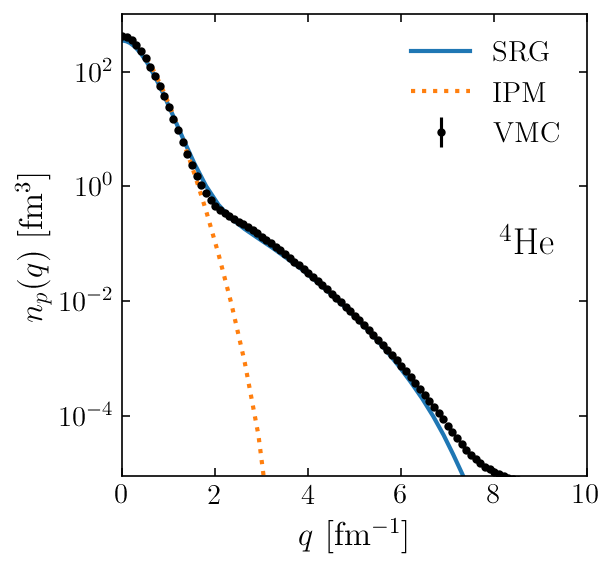

In [9]:
q_array, q_weights, n_array = proton_momentum_distribution(
    'He4', 2, 2, 2, 1, ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1'), 6,
    print_normalization=True, show_vmc=True, save=True
)

SRG normalization = 1.9814716288591563.
IPM normalization = 2.0033039451427594.
VMC normalization = 2.000031875649773.


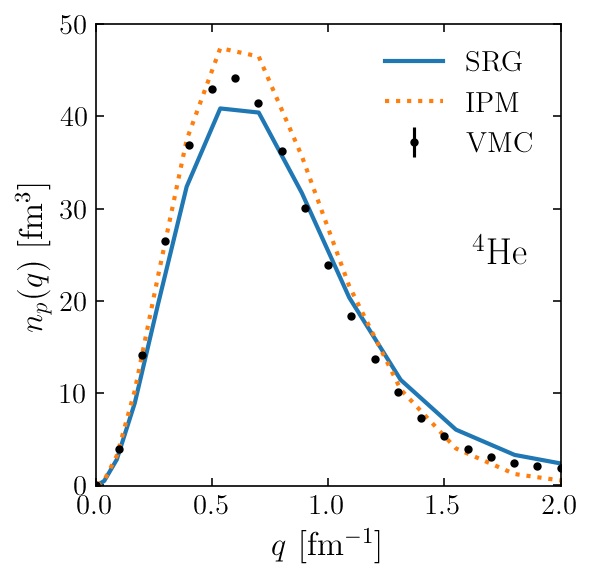

In [10]:
q_array, q_weights, n_array = proton_momentum_distribution(
    'He4', 2, 2, 2, 1, ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1'), 6,
    print_normalization=True, show_vmc=True, y_scale='linear',
    x_limits=(0.0,2.0), y_limits=(-0.1,50), save=True
)

Total normalization = 1.9814716288591563.
I normalization = 2.0033039451427594.
\delta U + \delta U^\dagger normalization = -0.2023886286491095.
\delta U \delta U^\dagger normalization = 0.1805563123655062.


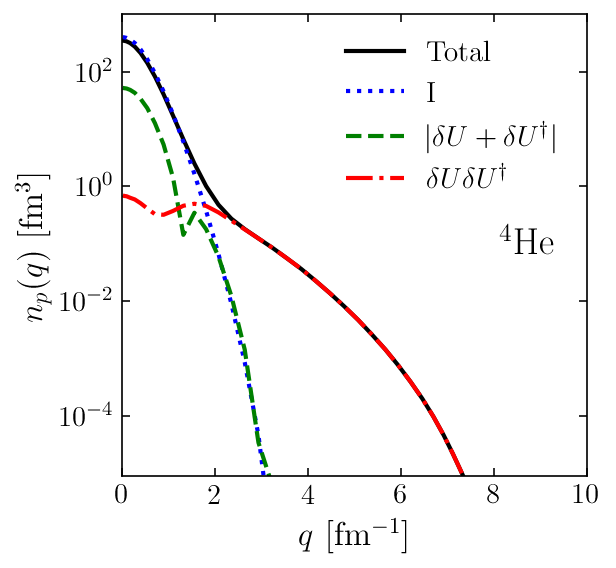

In [14]:
q_array, q_weights, n_array = momentum_distribution_contributions(
    'He4', 2, 2, 2, 1, ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1'), 6,
    print_normalization=True, show_vmc=False, save=True
)

 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           2           2
 j=           5           5
 wood saxon ordering
 n=           1           1
 l=           0           2
 j=           1           3
 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           2           2
 j=           5           5
 wood saxon ordering
 n=           1           1
 l=   

KeyboardInterrupt: 

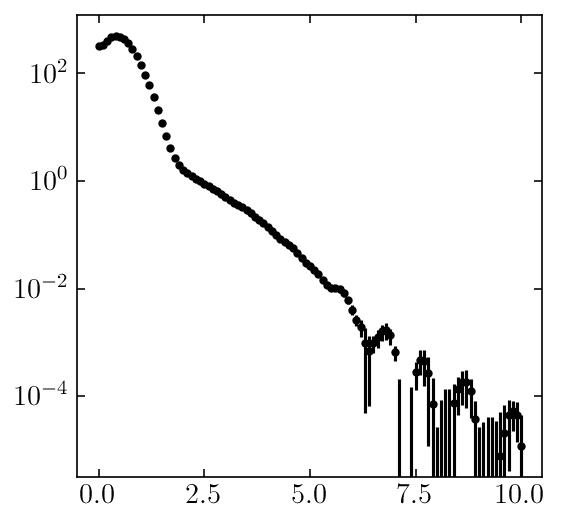

In [11]:
# q_array, q_weights, n_array = proton_momentum_distribution(
#     'O16', 8, 8, 2, 2, ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1'), 6,
#     print_normalization=True, show_vmc=True, y_limits=(9e-6,1e3), save=True
# )

In [ ]:
# q_array, q_weights, n_array = proton_momentum_distribution(
#     'O16', 8, 8, 2, 2, ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1'), 6,
#     print_normalization=True, y_scale='linear', x_limits=(0.0,2.0),
#     y_limits=(-0.1,700.0), save=True
# )